In [2]:
import sys
import os
import re
import glob
import pandas as pd
import numpy as np

In [207]:
pattern_runtime = re.compile(r'Total Wall')
pattern_energy = re.compile(r'Total CPU energy consumed')
pattern_mpi = re.compile(r'halo exchange time')
pattern_reduction = re.compile(r'reduction time')

#dataframe with columns: app, variant, opt, nodes, size, runtime, energy, mpi, reduction
rows = []

directory = 'ops_scaling_archer2' #sys.argv[1]
for filename in glob.glob(directory + "/*diag2"):
    with open(filename, 'r') as f:
        lines = f.readlines()
        runtime = []
        energy = []
        mpi = []
        reduction = []
        count = 0
        #collect all results from the given file
        for line in lines:
            if pattern_runtime.search(line):
                numbers = re.findall(r'[-+]?\d*\.\d+|\d+', line)
                runtime.append(float(numbers[0]))
                count += 1
            if pattern_energy.search(line):
                numbers = re.findall(r'[-+]?\d*\.\d+|\d+', line)
                energy.append(float(numbers[0]))
            if pattern_mpi.search(line):
                numbers = re.findall(r'[-+]?\d*\.\d+|\d+', line)
                mpi.append(float(numbers[0]))
            if pattern_reduction.search(line):
                numbers = re.findall(r'[-+]?\d*\.\d+|\d+', line)
                reduction.append(float(numbers[0]))
        #if there is more than one result, remove worse, take the average
        if count > 1:
            max_runtime_index = np.argmax(runtime)
            runtime.remove(runtime[max_runtime_index])
            runtime = np.mean(runtime)
            if len(energy) > 1:
                energy.remove(energy[max_runtime_index])
            energy = np.mean(energy)
            if len(mpi) > 1:
                mpi.remove(mpi[max_runtime_index])
            mpi = np.mean(mpi)
            if len(reduction) > 1:
                reduction.remove(reduction[max_runtime_index])
            reduction = np.mean(reduction)
        else:
            runtime = runtime[0]
            if len(energy) > 0:
                energy = energy[0]
            else:
                energy = 0
            if len(mpi) > 0:
                mpi = mpi[0]
            else:
                mpi = 0
            if len(reduction) > 0:
                reduction = reduction[0]
            else:
                reduction = 0
        
        filename_components = filename.split('/')[-1].split('_')
        app = filename_components[0]
        variant = filename_components[1]
        if filename_components[2].isdigit():
            opt = ''
            nodes = int(filename_components[2])
            size = '_'.join(filename_components[3:-1])
        else:
            opt = filename_components[2]
            nodes = int(filename_components[3])
            size = '_'.join(filename_components[4:-1])

        stype = 'weak'
        if app == 'c2d' and size == '18000_18000':
            stype = 'strong'
        if app == 'c3d' and size == '600_600_600':
            stype = 'strong'
        if app == 'sn' and size == '640_640_640':
            stype = 'strong'
        if app == 'sa' and size == '476_476_476':
            stype = 'strong'

        new_row = {'app': app, 'variant': variant, 'opt': opt, 'nodes': nodes, 'stype': stype, 'size': size, 'runtime': runtime, 'energy': energy, 'mpi': mpi, 'reduction': reduction}
        rows.append(new_row)

df = pd.DataFrame(rows)
df['mpifraction'] = df['mpi'] / df['runtime'] * 100
df.head()


/Users/reguly/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/reguly/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,app,variant,opt,nodes,stype,size,runtime,energy,mpi,reduction,mpifraction
0,sa,mpiomp,tiled,64,weak,1536_1536_1536,25.882492,NaN,1.350770,NaN,5.218856
1,c3d,mpiomp,tiled,256,weak,3264_3264_1632,20.986559,0.0,3.304480,1.51609,15.745697
2,sa,mpi,,512,strong,476_476_476,0.623676,0.0,0.567054,0.00000,90.921248
3,sn,mpiomp,tiledcomm,4,strong,640_640_640,23.676674,NaN,0.726930,NaN,3.070237
4,sn,mpi,tiledcomm,16,weak,2048_1024_1024,39.486458,NaN,5.283490,NaN,13.380511


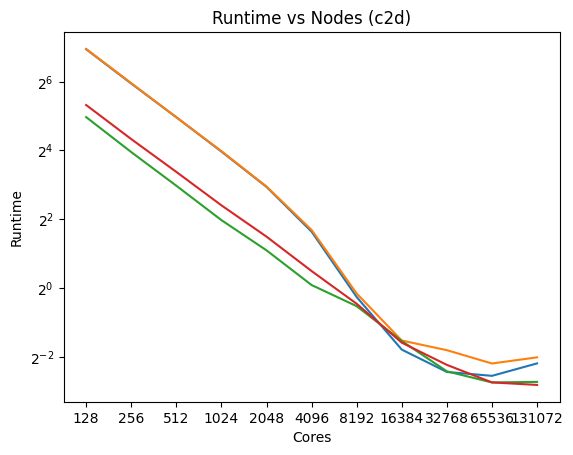

In [208]:
import matplotlib.pyplot as plt

df_c2d = df[(df['app'] == 'c2d') & (df['variant'] == 'mpi') & (df['opt'] == '') & (df['stype'] == 'strong')].sort_values(by='nodes')
df_c2d_mpiomp = df[(df['app'] == 'c2d') & (df['variant'] == 'mpiomp') & (df['opt'] == '') & (df['stype'] == 'strong')].sort_values(by='nodes')
df_c2d_tiled = df[(df['app'] == 'c2d') & (df['variant'] == 'mpi') & (df['opt'] == 'tiled') & (df['stype'] == 'strong')].sort_values(by='nodes')
df_c2d_mpiomp_tiled = df[(df['app'] == 'c2d') & (df['variant'] == 'mpiomp') & (df['opt'] == 'tiled') & (df['stype'] == 'strong')].sort_values(by='nodes')

plt.plot(df_c2d['nodes']*128, df_c2d['runtime'])
plt.plot(df_c2d_mpiomp['nodes']*128, df_c2d_mpiomp['runtime'])
plt.plot(df_c2d_tiled['nodes']*128, df_c2d_tiled['runtime'])
plt.plot(df_c2d_mpiomp_tiled['nodes']*128, df_c2d_mpiomp_tiled['runtime'])
plt.yscale('log', base=2)
plt.xscale('log', base=2)
plt.xticks(df_c2d['nodes']*128, df_c2d['nodes']*128)
plt.xlabel('Cores')
plt.ylabel('Runtime')
plt.title('Runtime vs Nodes (c2d)')
plt.show()

In [209]:
import matplotlib.pyplot as plt

def plot_runtime(df, app, stype, column='runtime', ylabel='Runtime', scale='log'):
    df_c2d = df[(df['app'] == app) & (df['variant'] == 'mpi') & (df['opt'] == '') & (df['stype'] == stype)].sort_values(by='nodes')
    df_c2d_mpiomp = df[(df['app'] == app) & (df['variant'] == 'mpiomp') & (df['opt'] == '') & (df['stype'] == stype)].sort_values(by='nodes')
    df_c2d_tiled = df[(df['app'] == app) & (df['variant'] == 'mpi') & (df['opt'] == 'tiled') & (df['stype'] == stype)].sort_values(by='nodes')
    df_c2d_mpiomp_tiled = df[(df['app'] == app) & (df['variant'] == 'mpiomp') & (df['opt'] == 'tiled') & (df['stype'] == stype)].sort_values(by='nodes')
    # print(df_c2d_mpiomp_tiled)
    plt.plot(df_c2d['nodes'], df_c2d[column])
    plt.plot(df_c2d_mpiomp['nodes'], df_c2d_mpiomp[column])
    plt.plot(df_c2d_tiled['nodes'], df_c2d_tiled[column])
    plt.plot(df_c2d_mpiomp_tiled['nodes'], df_c2d_mpiomp_tiled[column])
    plt.xscale('log', base=2)
    if scale == 'log':
        plt.yscale('log', base=2)
        plt.xticks(df_c2d['nodes'])
        #find the closest power of 2 to the max value
        max_value = max(df_c2d[column].max(), df_c2d_mpiomp[column].max(), df_c2d_tiled[column].max(), df_c2d_mpiomp_tiled[column].max())
        min_value = min(df_c2d[column].min(), df_c2d_mpiomp[column].min(), df_c2d_tiled[column].min(), df_c2d_mpiomp_tiled[column].min())
        closest_power_of_2_max = 2 ** int(np.log2(max_value))
        closest_power_of_2_min = 2 ** int(np.log2(min_value))
        plt.yticks(ticks=[2**i for i in range(int(np.log2(min_value)),int(np.log2(max_value))+1)], labels=[str(2**i) for i in range(int(np.log2(min_value)),int(np.log2(max_value))+1)])
        # plt.yticks(ticks=[2**i for i in range(-3,4)], labels=[str(2**i) for i in range(-3,4)])

    plt.xticks(df_c2d['nodes'])
    plt.xlabel('Nodes')
    plt.ylabel(ylabel)
    plt.legend(['mpi', 'mpiomp', 'mpi tiled', 'mpiomp tiled'])
    plt.title('Runtime vs Nodes (' + app + ')')
    plt.show()


def plot_runtime_sub(df, app, stype, column='runtime', ylabel='Runtime', scale='log', ax=plt):
    df_c2d = df[(df['app'] == app) & (df['variant'] == 'mpi') & (df['opt'] == '') & (df['stype'] == stype)].sort_values(by='nodes')
    df_c2d_mpiomp = df[(df['app'] == app) & (df['variant'] == 'mpiomp') & (df['opt'] == '') & (df['stype'] == stype)].sort_values(by='nodes')
    df_c2d_tiled = df[(df['app'] == app) & (df['variant'] == 'mpi') & (df['opt'] == 'tiled') & (df['stype'] == stype)].sort_values(by='nodes')
    df_c2d_mpiomp_tiled = df[(df['app'] == app) & (df['variant'] == 'mpiomp') & (df['opt'] == 'tiled') & (df['stype'] == stype)].sort_values(by='nodes')
    # print(df_c2d_mpiomp_tiled)
    ax.plot(df_c2d['nodes'], df_c2d[column])
    ax.plot(df_c2d_mpiomp['nodes'], df_c2d_mpiomp[column], marker='o', markersize=3)
    ax.plot(df_c2d_tiled['nodes'], df_c2d_tiled[column], linestyle='dashed')
    ax.plot(df_c2d_mpiomp_tiled['nodes'], df_c2d_mpiomp_tiled[column], linestyle='dashed', marker='o', markersize=3)
    ax.set_xscale('log', base=2)
    if scale == 'log':
        ax.set_yscale('log', base=2)
        # ax.set_xticks(df_c2d['nodes'])
        #find the closest power of 2 to the max value
        max_value = max(df_c2d[column].max(), df_c2d_mpiomp[column].max(), df_c2d_tiled[column].max(), df_c2d_mpiomp_tiled[column].max())
        min_value = min(df_c2d[column].min(), df_c2d_mpiomp[column].min(), df_c2d_tiled[column].min(), df_c2d_mpiomp_tiled[column].min())
        closest_power_of_2_max = 2 ** int(np.log2(max_value))
        closest_power_of_2_min = 2 ** int(np.log2(min_value))
        ax.set_yticks(ticks=[2**i for i in range(int(np.log2(min_value)),int(np.log2(max_value))+1)], labels=[str(2**i) for i in range(int(np.log2(min_value)),int(np.log2(max_value))+1)])
        # ax.set_yticks(ticks=[2**i for i in range(-3,4)], labels=[str(2**i) for i in range(-3,4)])
    else:
        max_value = max(df_c2d[column].max(), df_c2d_mpiomp[column].max(), df_c2d_tiled[column].max())
        ax.set_ylim(0, max_value*1.1)
    ax.set_xticks(df_c2d['nodes'])
    # ax.set_xlabel('Nodes')
    # ax.set_ylabel(ylabel)
    # ax.legend(['mpi', 'mpiomp', 'mpi tiled', 'mpiomp tiled'])
    # ax.set_title('Runtime vs Nodes (' + app + ')')
    if ax == plt:
        ax.show()




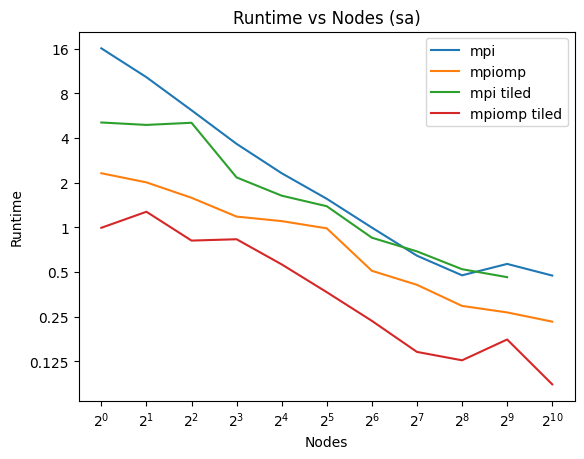

In [210]:
plot_runtime(df, 'sa', 'strong', 'mpi', ylabel='Runtime', scale='log')  

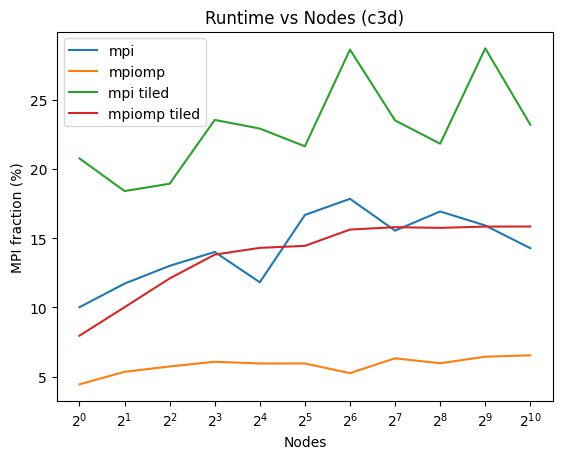

In [211]:
import matplotlib.pyplot as plt

df['mpifraction'] = df['mpi'] / df['runtime'] * 100
plot_runtime(df, 'c3d', 'weak', 'mpifraction', 'MPI fraction (%)', scale='linear')

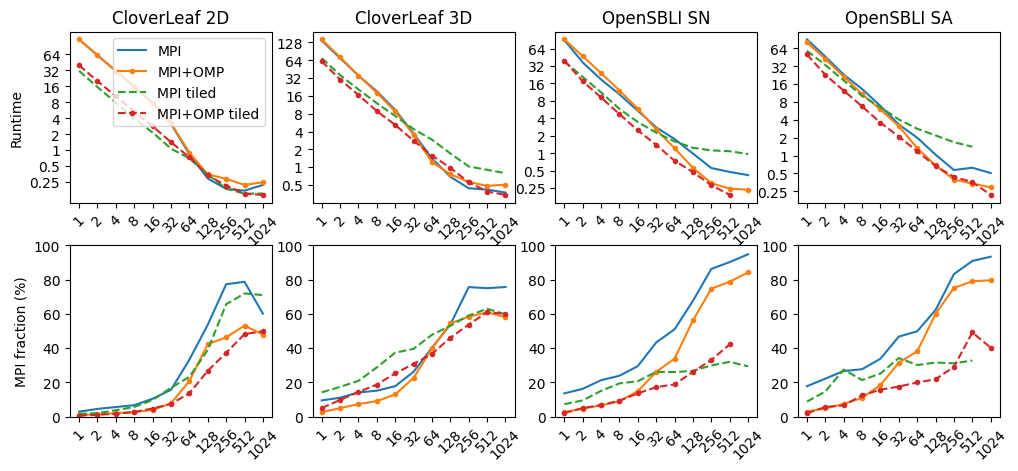

In [212]:

fig, axes = plt.subplots(2, 4, figsize=(12, 5))
fig.subplots_adjust(hspace=0.25)  # Increase spacing between rows
for i, ax in enumerate(axes.flatten()[0:4]):
    app = ['c2d', 'c3d', 'sn', 'sa'][i]
    title = ['CloverLeaf 2D', 'CloverLeaf 3D', 'OpenSBLI SN', 'OpenSBLI SA'][i]
    plot_runtime_sub(df, app, 'strong', 'runtime', ax=ax)
    if i == 0:
        ax.legend(['MPI', 'MPI+OMP', 'MPI tiled', 'MPI+OMP tiled'])
        ax.set_ylabel('Runtime')
    ax.set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
    ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], rotation=45)
    ax.set_title(title)
for i, ax in enumerate(axes.flatten()[4:8]):
    app = ['c2d', 'c3d', 'sn', 'sa'][i]
    plot_runtime_sub(df, app, 'strong', 'mpifraction', scale='linear', ax=ax)
    if i == 0:
        # ax.legend(['mpi', 'mpiomp', 'mpi tiled', 'mpiomp tiled'])
        ax.set_ylabel('MPI fraction (%)')
    ax.set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
    ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], rotation=45)
    ax.set_ylim(0, 100)
plt.show()
fig.savefig('archer2_strong.pdf')


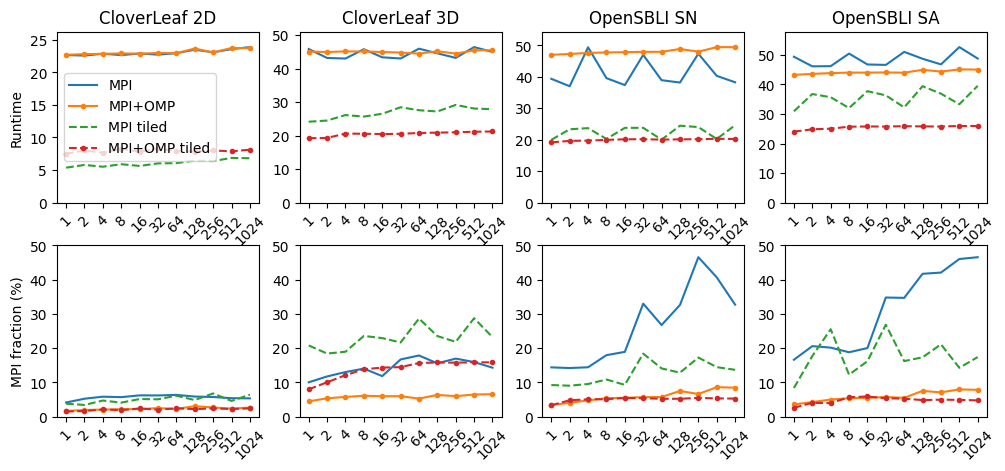

In [213]:

fig, axes = plt.subplots(2, 4, figsize=(12, 5))
fig.subplots_adjust(hspace=0.25)  # Increase spacing between rows
for i, ax in enumerate(axes.flatten()[0:4]):
    app = ['c2d', 'c3d', 'sn', 'sa'][i]
    title = ['CloverLeaf 2D', 'CloverLeaf 3D', 'OpenSBLI SN', 'OpenSBLI SA'][i]
    plot_runtime_sub(df, app, 'weak', 'runtime', scale='linear', ax=ax)
    if i == 0:
        ax.legend(['MPI', 'MPI+OMP', 'MPI tiled', 'MPI+OMP tiled'])
        ax.set_ylabel('Runtime')
    ax.set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
    ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], rotation=45)
    ax.set_title(title)
for i, ax in enumerate(axes.flatten()[4:8]):
    app = ['c2d', 'c3d', 'sn', 'sa'][i]
    plot_runtime_sub(df, app, 'weak', 'mpifraction', scale='linear', ax=ax)
    if i == 0:
        # ax.legend(['mpi', 'mpiomp', 'mpi tiled', 'mpiomp tiled'])
        ax.set_ylabel('MPI fraction (%)')
    ax.set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
    ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], rotation=45)
    ax.set_ylim(0, 50)
plt.show()
fig.savefig('archer2_weak.pdf')


In [233]:
def efficiency(app, stype):
    return df[(df['app'] == app) & (df['variant'] == 'mpiomp') & (df['opt'] == 'tiled') & (df['stype'] == stype) & (df['nodes'] == 1)]['runtime'].to_numpy()/df[(df['app'] == app) & (df['variant'] == 'mpiomp') & (df['opt'] == 'tiled') & (df['stype'] == stype) & (df['nodes'] == 512)]['runtime'].to_numpy()

print(efficiency('c2d', 'strong')/1024)
print(efficiency('c3d', 'strong')/1024)
print(efficiency('sn', 'strong')/1024)
print(efficiency('sa', 'strong')/1024)

[0.25825451]
[0.15527062]
[0.20237249]
[0.13862946]


In [234]:
pattern_runtime = re.compile(r'Total Wall')
pattern_energy = re.compile(r'Total CPU energy consumed')
pattern_mpi = re.compile(r'halo exchange time')
pattern_reduction = re.compile(r'reduction time')

#dataframe with columns: app, variant, opt, nodes, size, runtime, energy, mpi, reduction
rows = []

directory = '/Users/reguly/Work/MI250 benchmark/results_mi250x 2' #sys.argv[1]
for filename in glob.glob(directory + "/*diag2"):
    with open(filename, 'r') as f:
        lines = f.readlines()
        runtime = []
        energy = []
        mpi = []
        reduction = []
        count = 0
        init_mpi = 0
        init_mpi2 = []
        #collect all results from the given file
        for line in lines:
            if pattern_runtime.search(line):
                numbers = re.findall(r'[-+]?\d*\.\d+|\d+', line)
                runtime.append(float(numbers[0]))
                count += 1
            if pattern_energy.search(line):
                numbers = re.findall(r'[-+]?\d*\.\d+|\d+', line)
                energy.append(float(numbers[0]))
            if pattern_mpi.search(line):
                numbers = re.findall(r'[-+]?\d*\.\d+|\d+', line)
                mpi.append(float(numbers[0])-init_mpi)
                init_mpi2.append(init_mpi)
                init_mpi = 0
            if pattern_reduction.search(line):
                numbers = re.findall(r'[-+]?\d*\.\d+|\d+', line)
                reduction.append(float(numbers[0]))
            if 'chunk' in line:
                numbers = re.findall(r'[-+]?\d*\.\d+|\d+', line)
                init_mpi += float(numbers[3])
        #if there is more than one result, remove worse, take the average
        if count > 1:
            max_runtime_index = np.argmax(runtime)
            runtime.remove(runtime[max_runtime_index])
            runtime = np.mean(runtime)
            if len(energy) > 1:
                energy.remove(energy[max_runtime_index])
            energy = np.mean(energy)
            if len(mpi) > 1:
                mpi.remove(mpi[max_runtime_index])
            mpi = np.mean(mpi)
            if len(reduction) > 1:
                reduction.remove(reduction[max_runtime_index])
            reduction = np.mean(reduction)
            if len(init_mpi2) > 1:
                init_mpi2.remove(init_mpi2[max_runtime_index])
            init_mpi2 = np.mean(init_mpi2)
        else:
            if len(runtime) > 0:
                runtime = runtime[0]
            else:
                runtime = np.nan
            if len(energy) > 0:
                energy = energy[0]
            else:
                energy = 0
            if len(mpi) > 0:
                mpi = mpi[0]
            else:
                mpi = 0
            if len(reduction) > 0:
                reduction = reduction[0]
            else:
                reduction = 0
            if len(init_mpi2) > 0:
                init_mpi2 = init_mpi2[0]
            else:
                init_mpi2 = 0
        
        filename_components = filename.split('/')[-1].split('_')
        app = filename_components[0]
        if 'tiled' in filename:
            opt = 'Tiled+RDMA'
        elif 'direct' in filename:
            opt = 'RDMA'
        else:
            opt = 'Base'
        variant = 'HIP'
        nodes = int(filename_components[3])
        if app == 'c2d':
            size = '_'.join(filename_components[4:6])
        else:
            size = '_'.join(filename_components[4:7])

        stype = 'weak'
        if app == 'c2d' and size == '18000_18000':
            stype = 'strong'
        if app == 'c3d' and size == '600_600_600':
            stype = 'strong'
        if app == 'sn' and size == '640_640_640':
            stype = 'strong'
        if app == 'sa' and size == '476_476_476':
            stype = 'strong'

        new_row = {'app': app, 'variant': variant, 'opt': opt, 'nodes': nodes, 'stype': stype, 'size': size, 'runtime': runtime, 'energy': energy, 'mpi': mpi, 'reduction': reduction, 'init_mpi': init_mpi2}
        rows.append(new_row)

for row in rows:
    if (row['app'] == 'c2d' or row['app'] == 'c3d') and row['opt'] == 'Tiled+RDMA':
        for row2 in rows:
            if row2['app'] == row['app'] and row2['opt'] == 'RDMA' and row2['nodes'] == row['nodes'] and row2['size'] == row['size']:
                row['mpi'] = row['mpi'] - row2['init_mpi']
                break
            
df = pd.DataFrame(rows)
df.loc[(df['app'] == 'c3d') & (df['nodes'] == 4096) & (df['opt'] == 'Tiled+RDMA'), 'mpi'] = np.nan

df['mpifraction'] = df['mpi'] / df['runtime'] * 100
df.head()

def plot_runtime_sub_lumi(df, app, stype, column='runtime', ylabel='Runtime', scale='log', ax=plt):
    df_c2d = df[(df['app'] == app) & (df['variant'] == 'HIP') & (df['opt'] == 'Base') & (df['stype'] == stype)].sort_values(by='nodes')
    df_c2d_mpiomp = df[(df['app'] == app) & (df['variant'] == 'HIP') & (df['opt'] == 'RDMA') & (df['stype'] == stype)].sort_values(by='nodes')
    df_c2d_tiled = df[(df['app'] == app) & (df['variant'] == 'HIP') & (df['opt'] == 'Tiled+RDMA') & (df['stype'] == stype)].sort_values(by='nodes')

    # print(df_c2d_mpiomp_tiled)
    ax.plot(df_c2d['nodes'], df_c2d[column])
    ax.plot(df_c2d_mpiomp['nodes'], df_c2d_mpiomp[column], marker='o', markersize=3)
    ax.plot(df_c2d_tiled['nodes'], df_c2d_tiled[column], linestyle='dashed')
    # ax.plot(df_c2d_mpiomp_tiled['nodes'], df_c2d_mpiomp_tiled[column], linestyle='dashed', marker='o', markersize=3)
    ax.set_xscale('log', base=2)
    if scale == 'log':
        ax.set_yscale('log', base=2)
        # ax.set_xticks(df_c2d['nodes'])
        #find the closest power of 2 to the max value
        max_value = max(df_c2d[column].max(), df_c2d_mpiomp[column].max(), df_c2d_tiled[column].max())
        min_value = min(df_c2d[column].min(), df_c2d_mpiomp[column].min(), df_c2d_tiled[column].min())
        closest_power_of_2_max = 2 ** int(np.log2(max_value))
        closest_power_of_2_min = 2 ** int(np.log2(min_value))
        ax.set_yticks(ticks=[2**i for i in range(int(np.log2(min_value)),int(np.log2(max_value))+1)], labels=[str(2**i) for i in range(int(np.log2(min_value)),int(np.log2(max_value))+1)])
        # ax.set_yticks(ticks=[2**i for i in range(-3,4)], labels=[str(2**i) for i in range(-3,4)])
    else:
        max_value = max(df_c2d[column].max(), df_c2d_mpiomp[column].max(), df_c2d_tiled[column].max())
        ax.set_ylim(0, max_value*1.1)

    ax.set_xticks(df_c2d['nodes'])
    # ax.set_xlabel('Nodes')
    # ax.set_ylabel(ylabel)
    # ax.legend(['mpi', 'mpiomp', 'mpi tiled', 'mpiomp tiled'])
    # ax.set_title('Runtime vs Nodes (' + app + ')')
    if ax == plt:
        ax.show()



/Users/reguly/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/reguly/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


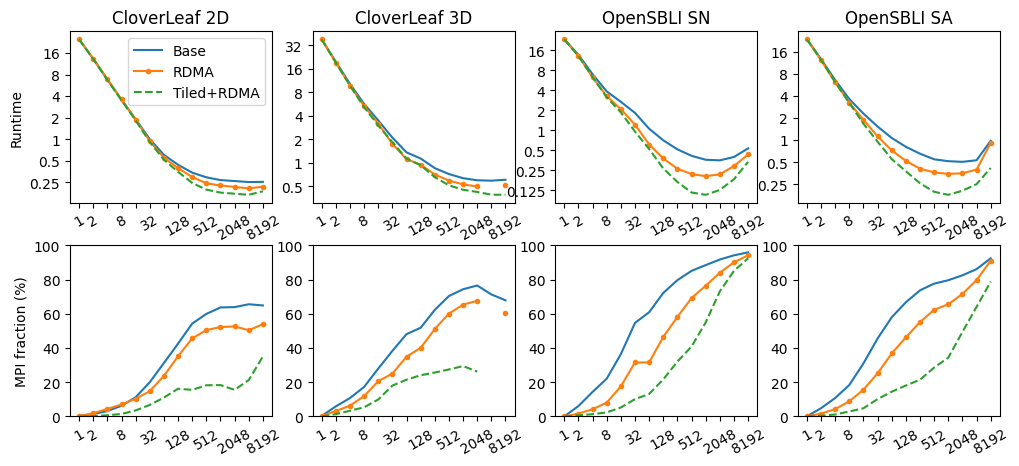

In [235]:

fig, axes = plt.subplots(2, 4, figsize=(12, 5))
fig.subplots_adjust(hspace=0.25)  # Increase spacing between rows
for i, ax in enumerate(axes.flatten()[0:4]):
    app = ['c2d', 'c3d', 'sn', 'sa'][i]
    title = ['CloverLeaf 2D', 'CloverLeaf 3D', 'OpenSBLI SN', 'OpenSBLI SA'][i]
    plot_runtime_sub_lumi(df, app, 'strong', 'runtime', ax=ax)
    if i == 0:
        ax.legend(['Base', 'RDMA', 'Tiled+RDMA'])
        ax.set_ylabel('Runtime')
    ax.set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192])
    ax.set_xticklabels([1, 2, '', 8, '', 32, '', 128, '', 512, '', 2048, '', 8192], rotation=30) 
    ax.set_title(title)
for i, ax in enumerate(axes.flatten()[4:8]):
    app = ['c2d', 'c3d', 'sn', 'sa'][i]
    plot_runtime_sub_lumi(df, app, 'strong', 'mpifraction', scale='linear', ax=ax)
    if i == 0:
        # ax.legend(['mpi', 'mpiomp', 'mpi tiled', 'mpiomp tiled'])
        ax.set_ylabel('MPI fraction (%)')
    ax.set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192])
    ax.set_xticklabels([1, 2, '', 8, '', 32, '', 128, '', 512, '', 2048, '', 8192], rotation=30) 
    ax.set_ylim(0, 100)
plt.show()
fig.savefig('lumi_strong.pdf')


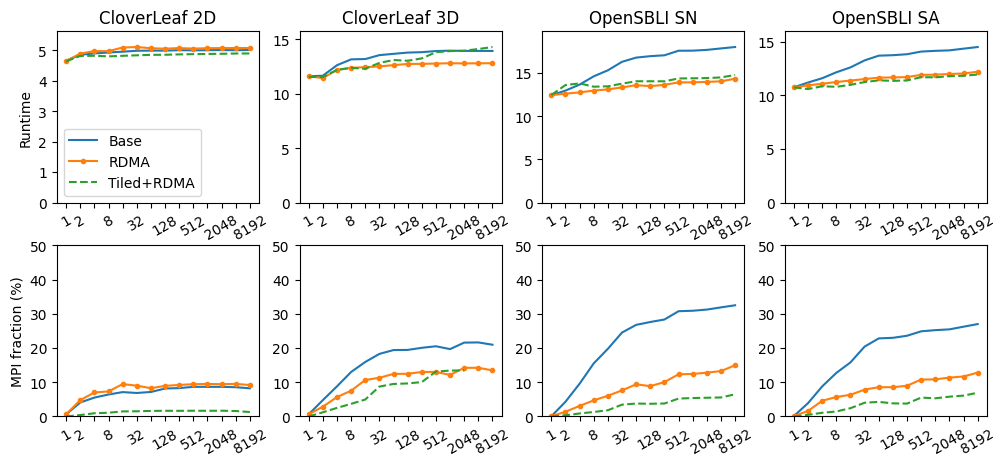

In [236]:

fig, axes = plt.subplots(2, 4, figsize=(12, 5))
fig.subplots_adjust(hspace=0.25)  # Increase spacing between rows
for i, ax in enumerate(axes.flatten()[0:4]):
    app = ['c2d', 'c3d', 'sn', 'sa'][i]
    title = ['CloverLeaf 2D', 'CloverLeaf 3D', 'OpenSBLI SN', 'OpenSBLI SA'][i]
    plot_runtime_sub_lumi(df, app, 'weak', 'runtime', scale='linear', ax=ax)
    if i == 0:
        ax.legend(['Base', 'RDMA', 'Tiled+RDMA'])
        ax.set_ylabel('Runtime')
    ax.set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192])
    ax.set_xticklabels([1, 2, '', 8, '', 32, '', 128, '', 512, '', 2048, '', 8192], rotation=30) 
    ax.set_title(title)
for i, ax in enumerate(axes.flatten()[4:8]):
    app = ['c2d', 'c3d', 'sn', 'sa'][i]
    plot_runtime_sub_lumi(df, app, 'weak', 'mpifraction', scale='linear', ax=ax)
    if i == 0:
        # ax.legend(['mpi', 'mpiomp', 'mpi tiled', 'mpiomp tiled'])
        ax.set_ylabel('MPI fraction (%)')
    ax.set_xticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192])
    ax.set_xticklabels([1, 2, '', 8, '', 32, '', 128, '', 512, '', 2048, '', 8192], rotation=30) 
    ax.set_ylim(0, 50)
plt.show()
fig.savefig('lumi_weak.pdf')


In [246]:
def efficiency(app, stype):
    return df[(df['app'] == app) & (df['variant'] == 'HIP') & (df['opt'] == 'RDMA') & (df['stype'] == stype) & (df['nodes'] == 1)]['runtime'].to_numpy()/df[(df['app'] == app) & (df['variant'] == 'HIP') & (df['opt'] == 'RDMA') & (df['stype'] == stype) & (df['nodes'] == 8192)]['runtime'].to_numpy()

print(efficiency('c2d', 'weak'))
print(efficiency('c3d', 'weak'))
print(efficiency('sn', 'weak'))
print(efficiency('sa', 'weak'))

[0.91692125]
[0.90664469]
[0.867194]
[0.88078863]
